In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

### Load dataset 

In [2]:
data = pd.read_csv('ratings.csv')
data['userId'] = data['userId'].astype('str')
data['movieId'] = data['movieId'].astype('str')
users = data['userId'].unique() #list of all users
movies = data['movieId'].unique() #list of all movies
print("Number of users", len(users))
print("Number of movies", len(movies))

Number of users 610
Number of movies 9724


In [3]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Train & Test split 

Оставляем в тесте 20% прос

In [4]:
test = pd.DataFrame(columns=data.columns)
train = pd.DataFrame(columns=data.columns)

In [5]:
test_ratio = 0.2

In [6]:
for u in users:
    temp = data[data['userId'] == u]
    n = len(temp)
    test_size = int(test_ratio*n)
    
    dummy_test = temp[n-1-test_size :]
    dummy_train = temp[: n-2-test_size]
    test = pd.concat([test, dummy_test])
    train = pd.concat([train, dummy_train])

исключаем фильмы из теста, которых нет в трейне 

In [7]:
train_movies_list = list(train["movieId"].unique())
test = test[test.movieId.isin(train_movies_list)]

In [8]:
train.shape

(79676, 4)

In [9]:
test.shape

(16894, 4)

### создание разреженной матрицы 

Создадим матрицу юзеры - фильмы для обучеия рекомендательной системы

In [10]:
train_utility_matrix = train.sort_values("movieId").pivot(index="userId", columns="movieId", values="rating").reset_index()

In [11]:
film_id_list_sort = list(train_utility_matrix.columns)
film_id_list_sort.remove("userId")
film_id_list_sort = [int(i) for i in film_id_list_sort]
film_id_list_sort.sort()
film_id_list_sort = [str(i) for i in film_id_list_sort]

In [12]:
train_utility_matrix = train_utility_matrix[["userId"] + film_id_list_sort]

Для Null фильмов проставим в качестве рейтинка среднююоценку по пользователям, которые оценили этот фильм

In [13]:
train_utility_matrix_non_zero = train_utility_matrix.fillna((train_utility_matrix[film_id_list_sort].mean()))

In [14]:
train_utility_matrix_non_zero.head()

movieId,userId,1,2,3,4,5,6,7,8,9,...,174053,174055,174479,175569,176371,177593,177765,183897,185029,187541
0,1,4.00000,3.431818,4.000000,2.357143,3.071429,4.000000,3.185185,2.875,3.125,...,5.0,4.0,4.0,1.5,1.0,5.0,2.5,1.5,1.0,1.0
1,10,3.92093,3.431818,3.259615,2.357143,3.071429,3.946078,3.185185,2.875,3.125,...,5.0,4.0,4.0,1.5,1.0,5.0,2.5,1.5,1.0,1.0
2,100,3.92093,3.431818,3.500000,2.357143,3.071429,3.946078,3.185185,2.875,3.125,...,5.0,4.0,4.0,1.5,1.0,5.0,2.5,1.5,1.0,1.0
3,101,3.92093,3.431818,3.259615,2.357143,3.071429,3.946078,3.185185,2.875,3.125,...,5.0,4.0,4.0,1.5,1.0,5.0,2.5,1.5,1.0,1.0
4,102,3.92093,3.431818,5.000000,2.357143,3.071429,3.000000,3.185185,2.875,3.125,...,5.0,4.0,4.0,1.5,1.0,5.0,2.5,1.5,1.0,1.0


In [15]:
userId_list = list(train_utility_matrix_non_zero["userId"])
movieId_list = film_id_list_sort

In [16]:
len(movieId_list)

7399

Создадим матрицу для обучения (svd-разложения)

In [17]:
X = np.array(train_utility_matrix_non_zero[film_id_list_sort])

In [18]:
X.shape

(610, 7399)

# SVD 

В качестве ранговой апроксимации возьмем параметр rank = 5

## np.linalg.svd 

In [20]:
%%time
U, s, V = np.linalg.svd(X)

Wall time: 11.2 s


In [21]:
s_diag = np.diag(np.array(list(s) + [0]*(V.shape[0] - s.shape[0])))[:610,:7399]

In [22]:
def create_lov_rank_matrix(U, s, V):
    s_diag = np.diag(np.array(list(s) + [0]*(V.shape[0] - s.shape[0])))[:610,:7399]
    return U[:, :rank], s_diag[:rank, :rank], V[:rank, :]

In [23]:
rank = 5
U_rank, s_diag_rank, V_rank = create_lov_rank_matrix(U, s, V)

###### Ошибка в точной апроксимации

In [24]:
error_matrix = (U@s_diag@V - X)**2
error_matrix.mean()

1.565622015901574e-27

###### Ошибка в малоранговой апроксимации

In [25]:
error_matrix_rank = (U_rank@s_diag_rank@V_rank - X)**2
error_matrix_rank.mean()

0.01215248931386438

###### ошибка на тестовой выборке 

Получим предикт для фильмов, которые попали в тест

In [26]:
def predictions_by_svd_matrix(X_pred_np):
    X_pred_pivot_pd = pd.concat([train_utility_matrix_non_zero[["userId"]],
                                 pd.DataFrame(X_pred_np, columns=movieId_list)],
                                axis=1)
    X_pred_pd = X_pred_pivot_pd.melt(id_vars=["userId"], value_vars=movieId_list,
                                     var_name='movieId', value_name='pred')
    return X_pred_pd

In [27]:
def create_rating_pred_matrix(X_pred_pd, true_score_pd):
    return X_pred_pd.merge(true_score_pd, on=["userId", "movieId"])

In [28]:
def mse_score(pred_df):
    delta_err = (np.array(pred_df["pred"]) - np.array(pred_df["rating"]))**2
    return delta_err.mean()

In [29]:
X_pred_np = U_rank@s_diag_rank@V_rank
X_pred_pd = predictions_by_svd_matrix(X_pred_np)

X_test_score_matrix = create_rating_pred_matrix(X_pred_pd, test)
X_train_score_matrix = create_rating_pred_matrix(X_pred_pd, train)

In [30]:
print("Ошибка на train: ", mse_score(X_train_score_matrix))
print("Ошибка на test: ", mse_score(X_test_score_matrix))

Ошибка на train:  0.6580079389045526
Ошибка на test:  1.0278064871936066


In [31]:
rank_list = [2, 4, 8, 16, 32, 64]

In [32]:
train_err = []
test_err = []

for rank in rank_list:
    U_rank, s_diag_rank, V_rank = create_lov_rank_matrix(U, s, V)
    X_pred_np = U_rank@s_diag_rank@V_rank
    X_pred_pd = predictions_by_svd_matrix(X_pred_np)
    X_test_score_matrix = create_rating_pred_matrix(X_pred_pd, test)
    X_train_score_matrix = create_rating_pred_matrix(X_pred_pd, train)
    train_err.append(mse_score(X_train_score_matrix))
    test_err.append(mse_score(X_test_score_matrix))

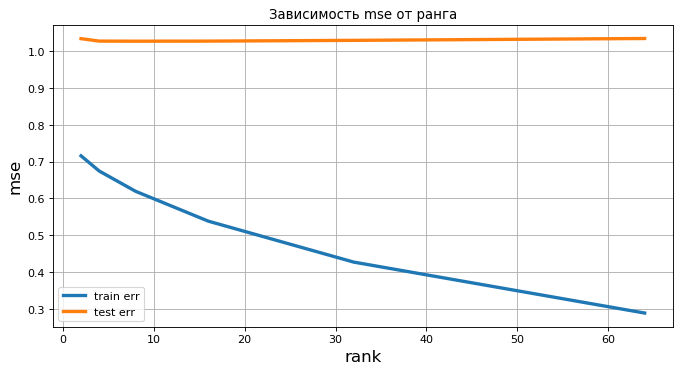

In [33]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title("Зависимость mse от ранга")
plt.grid(True)
plt.plot(rank_list, train_err, linewidth=3, label="train err")
plt.plot(rank_list, test_err, linewidth=3, label="test err")

plt.xlabel('rank',fontsize=15)
plt.ylabel('mse', fontsize=15)
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

# randomized svd 

In [34]:
from sklearn.utils.extmath import randomized_svd

In [35]:
%%time
U_rand, Sigma_rand, VT_rand = randomized_svd(X, 
                                             n_components=610,
                                             n_iter=7,
                                             random_state=42)

Wall time: 4.21 s


In [36]:
Sigma_rand_diag = np.diag(np.array(list(Sigma_rand) + [0]*(VT_rand.shape[0] - Sigma_rand.shape[0])))[:610,:7399]

In [37]:
rank = 5
U_rank, s_diag_rank, V_rank = create_lov_rank_matrix(U_rand, Sigma_rand, VT_rand)

###### Ошибка в точной апроксимации 

In [38]:
error_matrix = (U_rand@Sigma_rand_diag@VT_rand - X)**2
error_matrix.mean()

1.703311309254929e-25

###### Ошибка в малоранговой апроксимации 

In [39]:
error_matrix_rank = (U_rank@s_diag_rank@V_rank - X)**2
error_matrix_rank.mean()

0.012152489313864392

###### зависимость ошибки на train/test от ранга 

In [40]:
rank_list = [2, 4, 8, 16, 32, 64]

In [41]:
train_err = []
test_err = []

for rank in rank_list:
    U_rank, s_diag_rank, V_rank = create_lov_rank_matrix(U_rand, Sigma_rand, VT_rand)
    X_pred_np = U_rank@s_diag_rank@V_rank
    X_pred_pd = predictions_by_svd_matrix(X_pred_np)
    X_test_score_matrix = create_rating_pred_matrix(X_pred_pd, test)
    X_train_score_matrix = create_rating_pred_matrix(X_pred_pd, train)
    train_err.append(mse_score(X_train_score_matrix))
    test_err.append(mse_score(X_test_score_matrix))

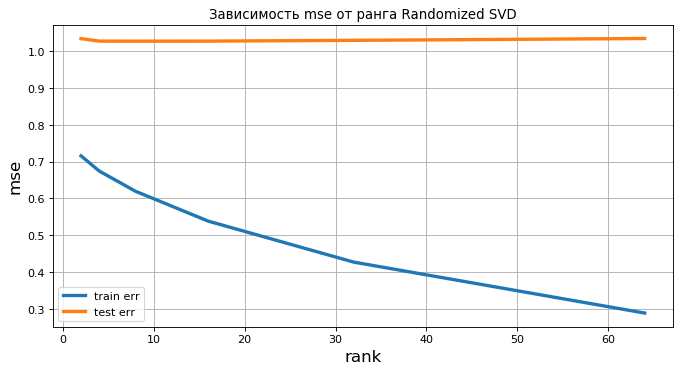

In [42]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title("Зависимость mse от ранга Randomized SVD")
plt.grid(True)
plt.plot(rank_list, train_err, linewidth=3, label="train err")
plt.plot(rank_list, test_err, linewidth=3, label="test err")

plt.xlabel('rank',fontsize=15)
plt.ylabel('mse', fontsize=15)
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

### custom randomized svd

In [43]:
import rand_pca

In [44]:
svd_custom_rand = rand_pca.RandPca()

In [46]:
%%time
U, s, V = svd_custom_rand.rsvd(X, k=610, q=7, l=610)

Wall time: 7.2 s


In [47]:
s_diag = np.diag(np.array(list(s) + [0]*(V.shape[0] - s.shape[0])))[:610,:7399]

In [48]:
rank = 5
U_rank, s_diag_rank, V_rank = create_lov_rank_matrix(U, s, V)

###### Ошибка в точной апроксимации 

In [49]:
error_matrix = (U@s_diag@V - X + 3.24)**2
error_matrix.mean()

0.00011954449077810414

###### Ошибка в малоранговой апроксимации 

In [50]:
error_matrix_rank = (U_rank@s_diag_rank@V_rank - X + 3.24)**2
error_matrix_rank.mean()

0.012268418941631859

###### зависимость ошибки на train/test от ранга 

In [51]:
rank_list = [2, 4, 8, 16, 32, 64]

In [52]:
train_err = []
test_err = []

for rank in rank_list:
    U_rank, s_diag_rank, V_rank = create_lov_rank_matrix(U, s, V)
    X_pred_np = U_rank@s_diag_rank@V_rank + 3.24
    X_pred_pd = predictions_by_svd_matrix(X_pred_np)
    X_test_score_matrix = create_rating_pred_matrix(X_pred_pd, test)
    X_train_score_matrix = create_rating_pred_matrix(X_pred_pd, train)
    train_err.append(mse_score(X_train_score_matrix))
    test_err.append(mse_score(X_test_score_matrix))

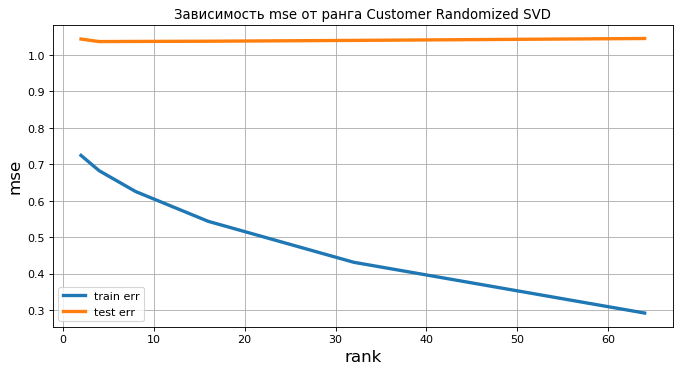

In [53]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title("Зависимость mse от ранга Customer Randomized SVD")
plt.grid(True)
plt.plot(rank_list, train_err, linewidth=3, label="train err")
plt.plot(rank_list, test_err, linewidth=3, label="test err")

plt.xlabel('rank',fontsize=15)
plt.ylabel('mse', fontsize=15)
# plt.yscale('log')
plt.legend(loc='best')
plt.show()